In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from texthero import stopwords, preprocessing
from math import log


In [111]:
#dump objects
import pickle as pkl

def dump_pickle(obj, file_name):
    pkl.dump(obj, open(file_name, 'wb'))

def write_file(data,name):
    with open(f'../data/{name}.index', 'w') as f:
        f.write(data)


In [3]:
def preprocessing_pipeline(text):

    #Call remove_stopwords and pass the custom_stopwords list
    default_stopwords = stopwords.DEFAULT
    #add a list of stopwords to the stopwords
    stop_w = ["I","It","The", "-","'", "."]
    custom_stopwords = default_stopwords.union(set(stop_w))

    # creating a custom pipeline to preprocess the raw text we have
    custom_pipeline = [preprocessing.lowercase
                    , preprocessing.fillna
                    , preprocessing.remove_diacritics
                    , preprocessing.remove_whitespace
                    , preprocessing.remove_angle_brackets
                    , preprocessing.remove_brackets
                    , preprocessing.remove_curly_brackets
                    , preprocessing.remove_html_tags
                    , preprocessing.remove_punctuation
                    ]
    
    # simply call clean() method to clean the raw text in ' comments' col and pass the custom_pipeline to pipeline argument
    text = hero.clean(text, pipeline = custom_pipeline)
    text = hero.remove_stopwords(text, custom_stopwords) 
    
    return text

In [4]:
df_train = pd.read_json("../data/train.jsonl",lines=True)
df_test_seen = pd.read_json("../data/test_seen.jsonl",lines=True)   
df_dev_seen = pd.read_json("../data/dev_seen.jsonl",lines=True)

In [5]:
df_train["type"] = "train"
df_test_seen["type"] = "test"
df_dev_seen["type"] = "val"

In [6]:
data = pd.concat([df_train, df_dev_seen, df_test_seen]).reset_index(drop=True)

<AxesSubplot:>

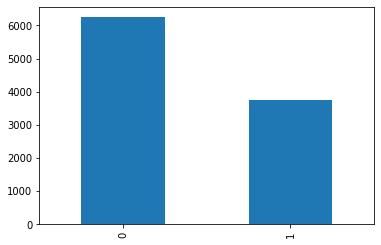

In [7]:
data.label.value_counts().plot(kind="bar")

<AxesSubplot:>

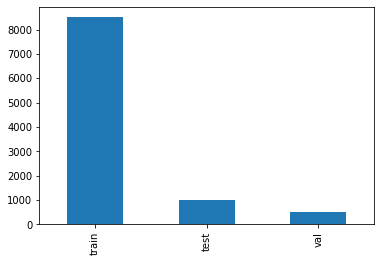

In [8]:
data.type.value_counts().plot(kind="bar")

In [13]:
data.head()

,id,img,label,text,type
0,42953,img/42953.png,0,its their character not their color that matters,train
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,train
2,13894,img/13894.png,0,putting bows on your pet,train
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,train
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",train


In [14]:
# data = data.sample(frac=1)
# data.head()


In [15]:
labels = data.label.to_list()

In [106]:
train_index = data[(data.type == "train") | (data.type == 'val')].id.to_list()
test_index = data[data.type == "test"].id.to_list()

In [107]:
train_index = "\n".join(train_index)
test_index = "\n".join(test_index)

In [ ]:
data.to_csv("../data/all_data.csv", index=False)

### Build Vocab

In [16]:

# build vocab
def build_vocab(corpus):
    word_freq = {}
    word_set = set()
    for doc_words in corpus:
        words = doc_words.split()
        for word in words:
            word_set.add(word)

    vocab = list(word_set)
    vocab_size = len(vocab)

    vocab_str = '\n'.join(vocab)

    print(f"Creating vocab of size {vocab_size}")
    with open('../data/additional_data/meme_vocab.txt', 'w') as f:
        f.write(vocab_str)
    
    return vocab


In [17]:
# Get all unique words from the meme text
# save them in a file
corpus = data.text.to_list()
vocab = build_vocab(corpus)

Creating vocab of size 13551


In [18]:
# Finding the size of the train, val and test set
train_size = len(df_train)
test_size = len(df_test_seen)   
val_size = len(df_dev_seen)

### Finding embedding

In [61]:


word_embeddings_dim = 300
# word_vector_map = {}


def get_embedding(data_size,text_data,labels):

    row_x = []
    col_x = []
    data_x = []

    for i in range(data_size):
        doc_vec = np.array([0.0 for k in range(word_embeddings_dim)])
        doc_words = text_data[i]
        words = doc_words.split()
        doc_len = len(words)

        for j in range(word_embeddings_dim):
            row_x.append(i)
            col_x.append(j)
            data_x.append(doc_vec[j] / doc_len)  # doc_vec[j]/ doc_len
    
    # x = sp.csr_matrix((real_train_size, word_embeddings_dim), dtype=np.float32)
    x = sp.csr_matrix((data_x, (row_x, col_x)), shape=(data_size, word_embeddings_dim))

    # One hot encoding of labels
    y = []
    label_list = [0,1]
    for i in range(data_size):
        label = labels[i]
        one_hot = [0 for l in range(len(label_list))]
        label_index = label_list.index(label)
        one_hot[label_index] = 1
        y.append(one_hot)
    y = np.array(y)

    return x,y


In [62]:
train_data = data[data.type == "train"]['text'].to_list()
train_labels = data[data.type == "train"]['label'].to_list()
test_data = data[data.type == "test"]['text'].to_list()
test_labels = data[data.type == "test"]['label'].to_list()
val_data = data[data.type == "val"]['text'].to_list()
val_labels = data[data.type == "val"]['label'].to_list()

In [63]:
train_x, train_y = get_embedding(train_size,train_data,train_labels)
test_x, test_y = get_embedding(test_size,test_data,test_labels) 

In [57]:
# Initialize random weights for word embeddings
vocab_size = len(vocab)
word_vectors = np.random.uniform(-0.01, 0.01,(vocab_size, word_embeddings_dim))


In [51]:
# Combining training and validation data to train the model
train_val_data = train_data + val_data
train_val_labels = train_labels + val_labels


train_val_size = len(train_val_data)

In [90]:
row_allx = []
col_allx = []
data_allx = []

for i in range(train_val_size):
    doc_vec = np.array([0.0 for k in range(word_embeddings_dim)])
    doc_words = train_val_data[i]
    words = doc_words.split()
    doc_len = len(words)

    for j in range(word_embeddings_dim):
        row_allx.append(int(i))
        col_allx.append(j)
        # np.random.uniform(-0.25, 0.25)
        data_allx.append(doc_vec[j] / doc_len)  # doc_vec[j]/doc_len
        
for i in range(vocab_size):
    for j in range(word_embeddings_dim):
        row_allx.append(int(i + train_size))
        col_allx.append(j)
        data_allx.append(word_vectors.item((i, j)))


row_allx = np.array(row_allx)
col_allx = np.array(col_allx)
data_allx = np.array(data_allx)

allx = sp.csr_matrix(
    (data_allx, (row_allx, col_allx)), shape=(train_val_size + vocab_size, word_embeddings_dim))

In [75]:
ally = []

label_list = [0,1]

# One hot encoding of labels of meme text (documents)
for i in range(train_val_size):
    label = train_val_labels[i]
    one_hot = [0 for l in range(len(label_list))]
    label_index = label_list.index(label)
    one_hot[label_index] = 1
    ally.append(one_hot)

# Assigning label 0 to all words
for i in range(vocab_size):
    one_hot = [0 for l in range(len(label_list))]
    ally.append(one_hot)

ally = np.array(ally)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape, allx.shape, ally.shape)

(8500, 300) (8500, 2) (1000, 300) (1000, 2) (22551, 300) (22551, 2)


In [84]:
'''
Doc word heterogeneous graph
'''

word_id_map = {}
for i in range(vocab_size):
    word_id_map[vocab[i]] = i

# word co-occurence with context windows
window_size = 20
windows = []

for doc_words in train_val_data:
    words = doc_words.split()
    length = len(words)
    if length <= window_size:
        windows.append(words)
    else:
        # print(length, length - window_size + 1)
        for j in range(length - window_size + 1):
            window = words[j: j + window_size]
            windows.append(window)
            # print(window)


word_window_freq = {}
for window in windows:
    appeared = set()
    for i in range(len(window)):
        if window[i] in appeared:
            continue
        if window[i] in word_window_freq:
            word_window_freq[window[i]] += 1
        else:
            word_window_freq[window[i]] = 1
        appeared.add(window[i])

word_pair_count = {}
for window in windows:
    for i in range(1, len(window)):
        for j in range(0, i):
            word_i = window[i]
            word_i_id = word_id_map[word_i]
            word_j = window[j]
            word_j_id = word_id_map[word_j]
            if word_i_id == word_j_id:
                continue
            word_pair_str = str(word_i_id) + ',' + str(word_j_id)
            if word_pair_str in word_pair_count:
                word_pair_count[word_pair_str] += 1
            else:
                word_pair_count[word_pair_str] = 1
            # two orders
            word_pair_str = str(word_j_id) + ',' + str(word_i_id)
            if word_pair_str in word_pair_count:
                word_pair_count[word_pair_str] += 1
            else:
                word_pair_count[word_pair_str] = 1

row = []
col = []
weight = []

# pmi as weights

num_window = len(windows)

for key in word_pair_count:
    temp = key.split(',')
    i = int(temp[0])
    j = int(temp[1])
    count = word_pair_count[key]
    word_freq_i = word_window_freq[vocab[i]]
    word_freq_j = word_window_freq[vocab[j]]
    pmi = log((1.0 * count / num_window) /
              (1.0 * word_freq_i * word_freq_j/(num_window * num_window)))
    if pmi <= 0:
        continue
    row.append(train_val_size + i)
    col.append(train_val_size + j)
    weight.append(pmi)

In [85]:
from collections import Counter  # optimized way to do this

all_words = [words.split() for words in corpus]
all_words = list(np.concatenate(all_words).flat)

word_doc_freq = Counter(word.lower() for word in all_words)


In [86]:

# doc word frequency
doc_word_freq = {}

for doc_id in range(len(corpus)):
    doc_words = corpus[doc_id]
    words = doc_words.split()
    for word in words:
        word_id = word_id_map[word]
        doc_word_str = str(doc_id) + ',' + str(word_id)
        if doc_word_str in doc_word_freq:
            doc_word_freq[doc_word_str] += 1
        else:
            doc_word_freq[doc_word_str] = 1

for i in range(len(corpus)):
    doc_words = corpus[i]
    words = doc_words.split()
    doc_word_set = set()
    for word in words:
        if word in doc_word_set:
            continue
        j = word_id_map[word]
        key = str(i) + ',' + str(j)
        freq = doc_word_freq[key]
        if i < train_size:
            row.append(i)
        else:
            row.append(i + vocab_size)
        col.append(train_val_size + j)
        idf = log(1.0 * len(corpus) /
                  word_doc_freq[vocab[j]])
        weight.append(freq * idf)
        doc_word_set.add(word)

node_size = train_val_size + vocab_size + test_size
adj = sp.csr_matrix(
    (weight, (row, col)), shape=(node_size, node_size))

In [93]:
dump_pickle(train_x, "../data/additional_data/ind.x")
dump_pickle(train_y, "../data/additional_data/ind.y")
dump_pickle(test_x, "../data/additional_data/ind.tx")
dump_pickle(test_y, "../data/additional_data/ind.ty")
dump_pickle(allx, "../data/additional_data/ind.allx")
dump_pickle(ally, "../data/additional_data/ind.ally")
dump_pickle(adj, "../data/additional_data/ind.adj")

In [89]:
data.to_csv("../data/additional_data/meme_data.csv", index=False)